No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


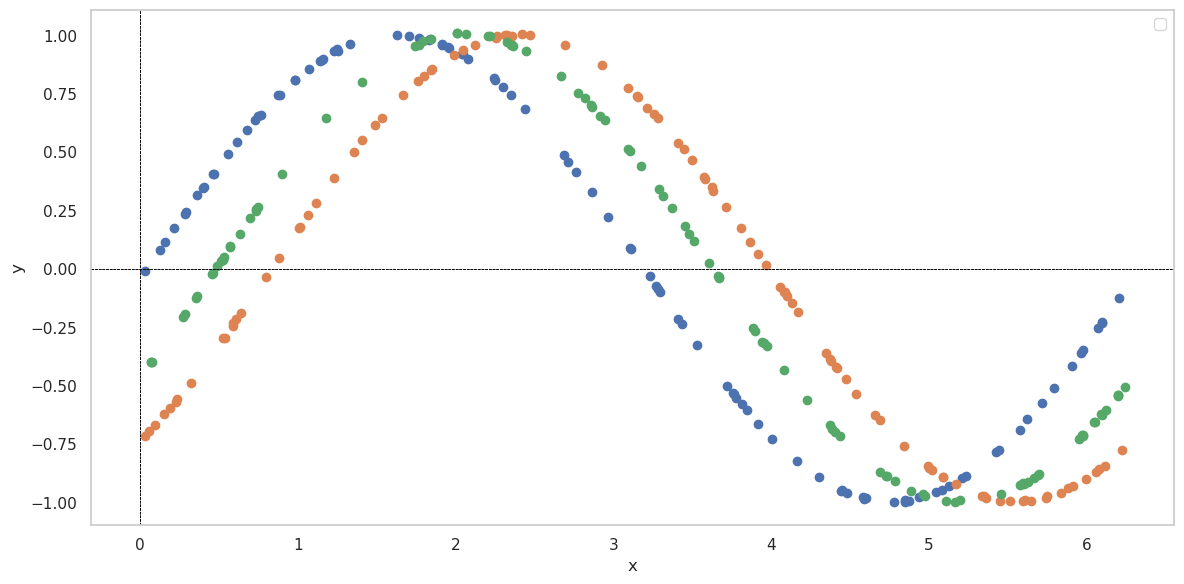

x_tensor shape: torch.Size([100, 100, 1])
y_tensor shape: torch.Size([100, 100, 1])
y_tensor_true shape: torch.Size([100, 100, 1])


In [16]:
# 1. Create sin function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
from scipy.stats import skew

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
num_train = 100
num_samples = 100
x_all = []
y_all = []
y_all_true = []


for _ in range(num_train):
    x = np.random.uniform(0, 2*np.pi, num_samples)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    shift = np.random.uniform(0, 0.5*np.pi) 
    y = 1*np.sin(x - shift) + np.random.uniform(0,0.01,num_samples)  
    y_true = 1*np.sin(x-shift)
    x_all.append(x)
    y_all.append(y)
    y_all_true.append(y_true)

x_all = np.array(x_all)
y_all = np.array(y_all)
y_all_true = np.array(y_all_true)

x_tensor = torch.FloatTensor(x_all)  
y_tensor = torch.FloatTensor(y_all)  
y_tensor_true = torch.FloatTensor(y_all_true)  

x_tensor = x_tensor.view(num_train, num_samples, 1)  
y_tensor = y_tensor.view(num_train, num_samples, 1)  
y_tensor_true = y_tensor_true.view(num_train, num_samples, 1)  

dataset = TensorDataset(x_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

plt.figure(figsize=(12, 6))
for i in range(3):  
    plt.scatter(x_all[i], y_all[i])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

print("x_tensor shape:", x_tensor.shape)  
print("y_tensor shape:", y_tensor.shape)  
print("y_tensor_true shape:", y_tensor_true.shape) 

In [17]:
# 2. Create Model

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_samples, 64)  
        self.bn1 = nn.BatchNorm1d(64) 
        self.fc2 = nn.Linear(64, 64)
        self.bn2 = nn.BatchNorm1d(64)  
        self.fc3 = nn.Linear(64, num_samples)  
        self.rectification = False
        self.istest = False
        self.act = []
        self.threshold = 3

    def forward(self, x):
        x = x.view(-1, num_samples)  
        x = torch.relu(self.bn1(self.fc1(x)))  
        x = self.bn2(self.fc2(x))
        x = torch.relu(x)  
        if self.istest:
            self.act.append(x)
        if self.rectification:
            x = torch.clip(x, min=0, max=self.threshold)


        x = self.fc3(x)
        return x.view(-1, num_samples, 1)  

    def clear_activations(self):
        self.act.clear()

    def change_threshold(self, c):
        self.threshold = c 


model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [18]:
# 3. Train Model
num_epochs = 1000
model.train()
model.rectification = False
model.istest = False
for epoch in range(num_epochs):
    for inputs, targets in data_loader:
        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(inputs)  # 예측
        loss = criterion(outputs, targets)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 매개변수 업데이트

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/1000], Loss: 0.4488
Epoch [20/1000], Loss: 0.3171
Epoch [30/1000], Loss: 0.2944
Epoch [40/1000], Loss: 0.2347
Epoch [50/1000], Loss: 0.2183
Epoch [60/1000], Loss: 0.1815
Epoch [70/1000], Loss: 0.1515
Epoch [80/1000], Loss: 0.1054
Epoch [90/1000], Loss: 0.1625
Epoch [100/1000], Loss: 0.1218
Epoch [110/1000], Loss: 0.1347
Epoch [120/1000], Loss: 0.0945
Epoch [130/1000], Loss: 0.1450
Epoch [140/1000], Loss: 0.0576
Epoch [150/1000], Loss: 0.0908
Epoch [160/1000], Loss: 0.0905
Epoch [170/1000], Loss: 0.0674
Epoch [180/1000], Loss: 0.0838
Epoch [190/1000], Loss: 0.1459
Epoch [200/1000], Loss: 0.1818
Epoch [210/1000], Loss: 0.0787
Epoch [220/1000], Loss: 0.0739
Epoch [230/1000], Loss: 0.0397
Epoch [240/1000], Loss: 0.0487
Epoch [250/1000], Loss: 0.0994
Epoch [260/1000], Loss: 0.0882
Epoch [270/1000], Loss: 0.0677
Epoch [280/1000], Loss: 0.0732
Epoch [290/1000], Loss: 0.1051
Epoch [300/1000], Loss: 0.1147
Epoch [310/1000], Loss: 0.0416
Epoch [320/1000], Loss: 0.0560
Epoch [330/1000],

Test Dataset RMSE: 0.1558
Bias: 0.0024
Variance: 0.4824


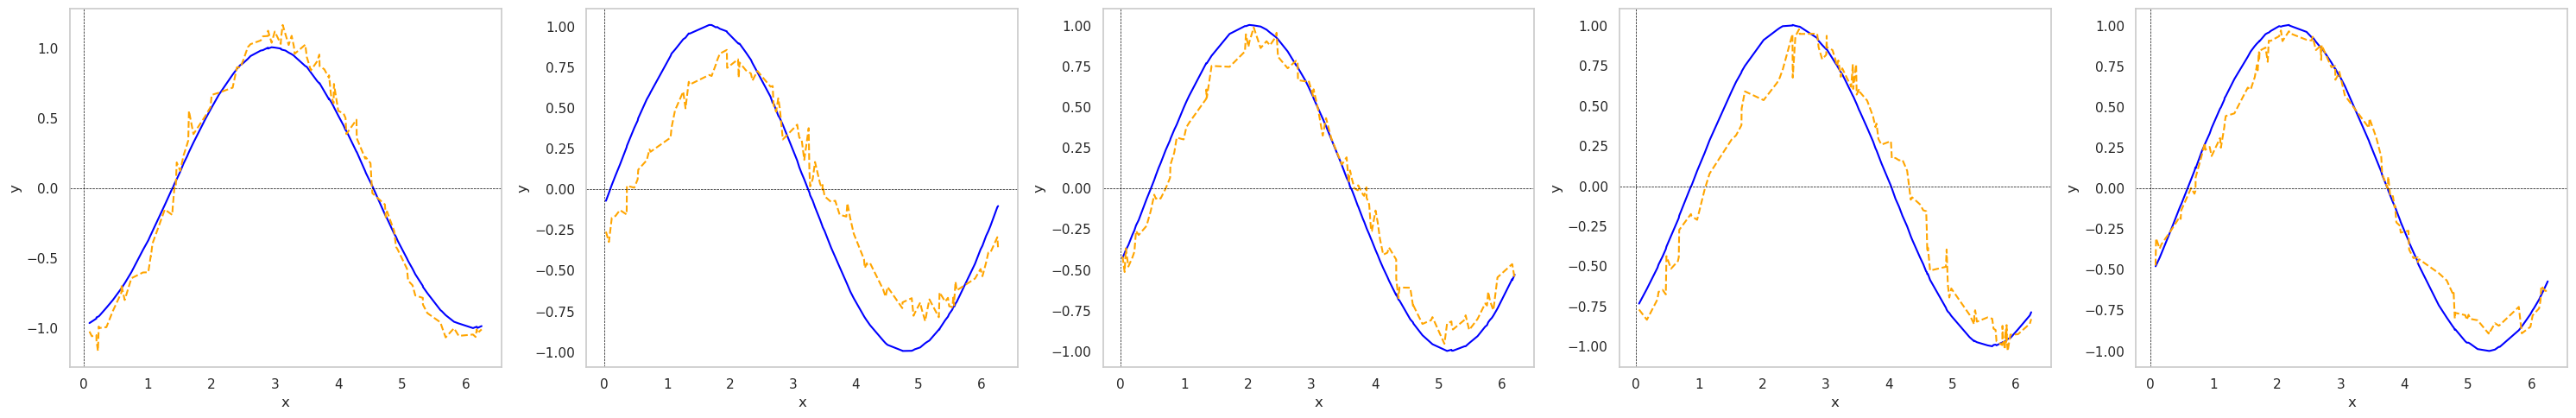

In [19]:
# 4. Train Dataset Evaluation

model.eval()  
model.rectification = False
model.istest = True
model.clear_activations()

with torch.no_grad():
    predictions = model(x_tensor).squeeze()  
    ground_truth = y_tensor_true.squeeze()  


rmse = torch.sqrt(torch.mean((predictions - ground_truth) ** 2)).item()
print(f"Test Dataset RMSE: {rmse:.4f}")

bias = torch.mean(predictions - ground_truth).item()
print(f"Bias: {bias:.4f}")

variance = torch.mean((predictions - torch.mean(predictions)) ** 2).item()
print(f"Variance: {variance:.4f}")

num_samples_to_visualize = 5
indices = np.random.choice(len(x_tensor), num_samples_to_visualize, replace=False)

plt.figure(figsize=(30, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.plot(x_all[index], y_all[index], label='True', color='blue')
    plt.plot(x_all[index], predictions[index].numpy().flatten(), label='Prediction', linestyle='--', color='orange')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

plt.tight_layout()
plt.show()


skewness of activations:  1.2940152681512713


/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


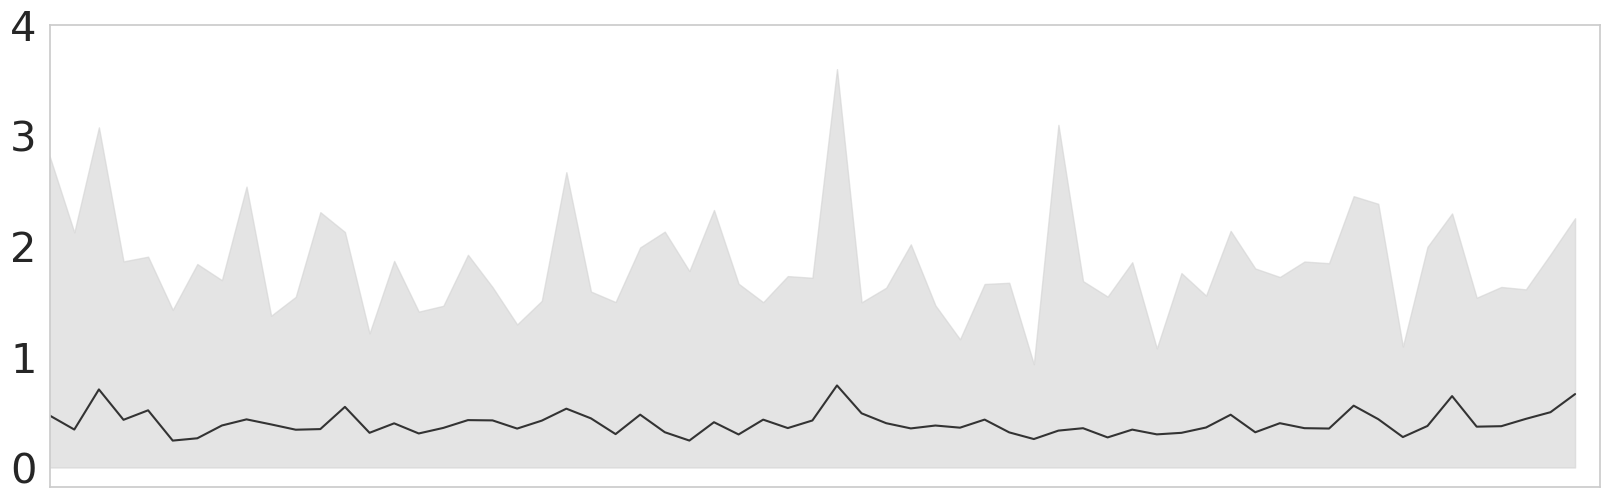

In [20]:
# 5. Activation Visualization on ID(In-Distribution)
act = model.act[0]  
act_np = act.cpu().detach().numpy()  
print("skewness of activations: ", skew(act_np.reshape(-1)))

activation_means = np.mean(act_np, axis=0)  
activation_max = np.max(act_np, axis=0)
activation_min = np.min(act_np, axis=0)

x = np.arange(len(activation_means))  

sns.set(style="whitegrid")

plt.figure(figsize=(20, 6))
plt.grid(False)
sns.lineplot(x=x, y=activation_means, color="#333333", linewidth=1.5) 

plt.fill_between(x, activation_min, activation_max, color="lightgray", alpha=0.6, label="Min-Max Region") 
plt.xticks([], fontsize=12)  
plt.xlim(1,64)
plt.yticks(ticks=np.arange(0, 5, 1), fontsize=30) 
plt.savefig("id_act.png")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


x_tensor shape: torch.Size([100, 100, 1])
y_tensor shape: torch.Size([100, 100, 1])
y_tensor_true shape: torch.Size([100, 100, 1])


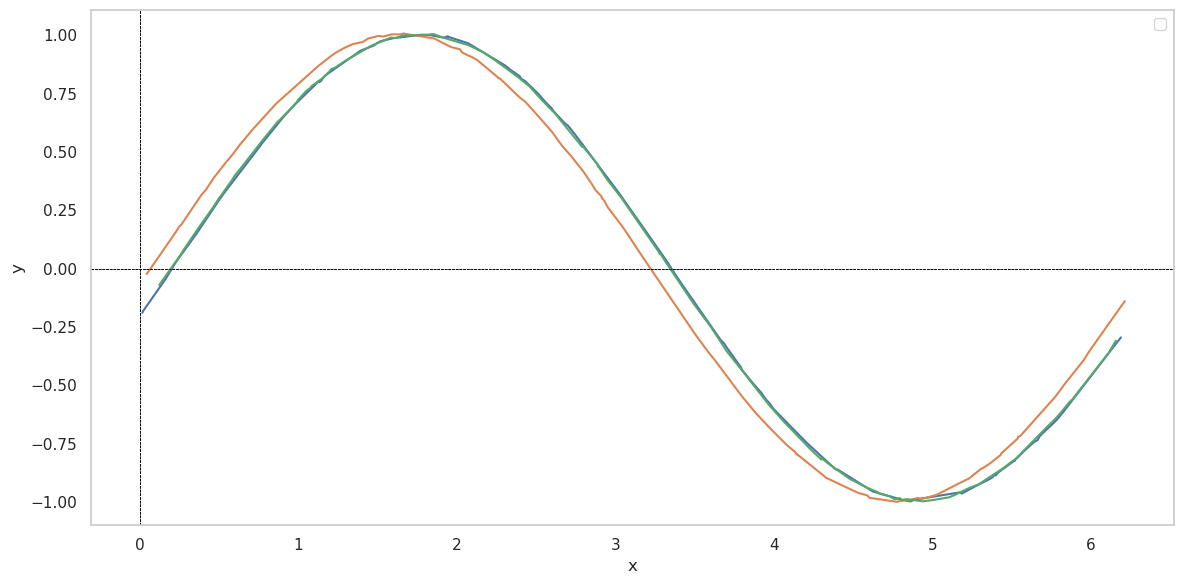

In [21]:
# 6. Create Domain Shift Data (Interpolation) Near Out-of-Distribution
num_test = 100
num_samples = 100
x_all = []
y_all = []
y_all_true = []

for _ in range(num_train):
    x = np.random.uniform(0, 2*np.pi, num_samples)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    shift = np.random.uniform(0, 0.1*np.pi) 
    y = 1*np.sin(x - shift) + np.random.uniform(0,0.01,num_samples)  
    y_true = 1*np.sin(x-shift)
    x_all.append(x)
    y_all.append(y)
    y_all_true.append(y_true)



x_all = np.array(x_all)
y_all = np.array(y_all)
y_all_true = np.array(y_all_true)

x_tensor = torch.FloatTensor(x_all)  
y_tensor = torch.FloatTensor(y_all)  
y_tensor_true = torch.FloatTensor(y_all_true) 

x_tensor = x_tensor.view(num_test, num_samples, 1) 
y_tensor = y_tensor.view(num_test, num_samples, 1)  
y_tensor_true = y_tensor_true.view(num_test, num_samples, 1) 

print("x_tensor shape:", x_tensor.shape) 
print("y_tensor shape:", y_tensor.shape)  
print("y_tensor_true shape:", y_tensor_true.shape)  

plt.figure(figsize=(12, 6))
for i in range(3):  # 3개의 샘플 추출
    plt.plot(x_all[i], y_all[i])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

Test Dataset RMSE: 0.5674
Bias: -0.0076
Variance: 0.4036


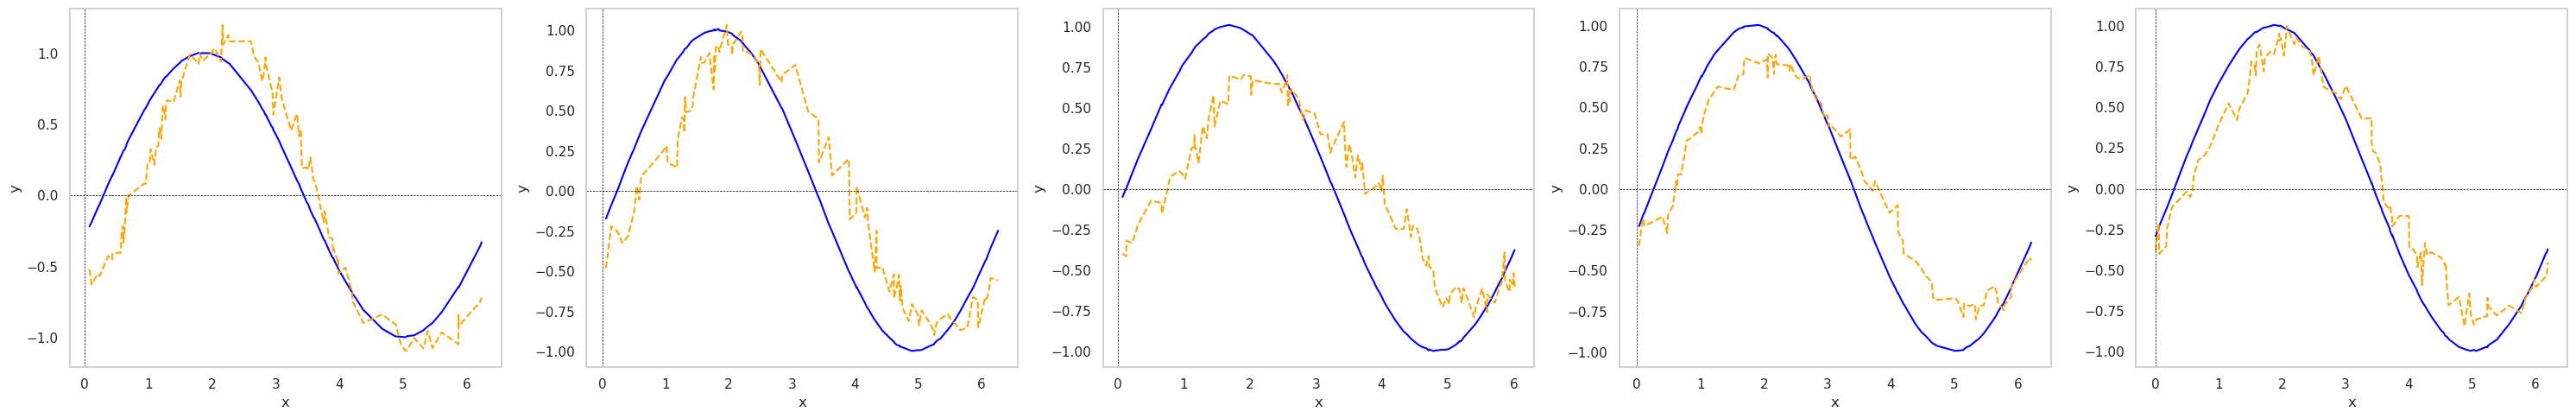

In [22]:
# 7. Evaluation on Domain Shift (Interpolation) without rectification

model.eval()  
model.rectification = False
model.istest = True
model.clear_activations()

with torch.no_grad():
    predictions = model(x_tensor).squeeze()  
    ground_truth = y_tensor_true.squeeze()  

rmse = torch.sqrt(torch.mean((predictions - ground_truth) ** 2)).item()
print(f"Test Dataset RMSE: {rmse:.4f}")

bias = torch.mean(predictions - ground_truth).item()
print(f"Bias: {bias:.4f}")

variance = torch.mean((predictions - torch.mean(predictions)) ** 2).item()
print(f"Variance: {variance:.4f}")

num_samples_to_visualize = 5
indices = np.random.choice(len(x_tensor), num_samples_to_visualize, replace=False)

plt.figure(figsize=(30, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.plot(x_all[index], y_all[index], label='True', color='blue')
    plt.plot(x_all[index], predictions[index].numpy().flatten(), label='Prediction', linestyle='--', color='orange')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

plt.savefig("near_ood_no_react_sin.png")
plt.tight_layout()
plt.show()

skewness: 1.4117686375096303


/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


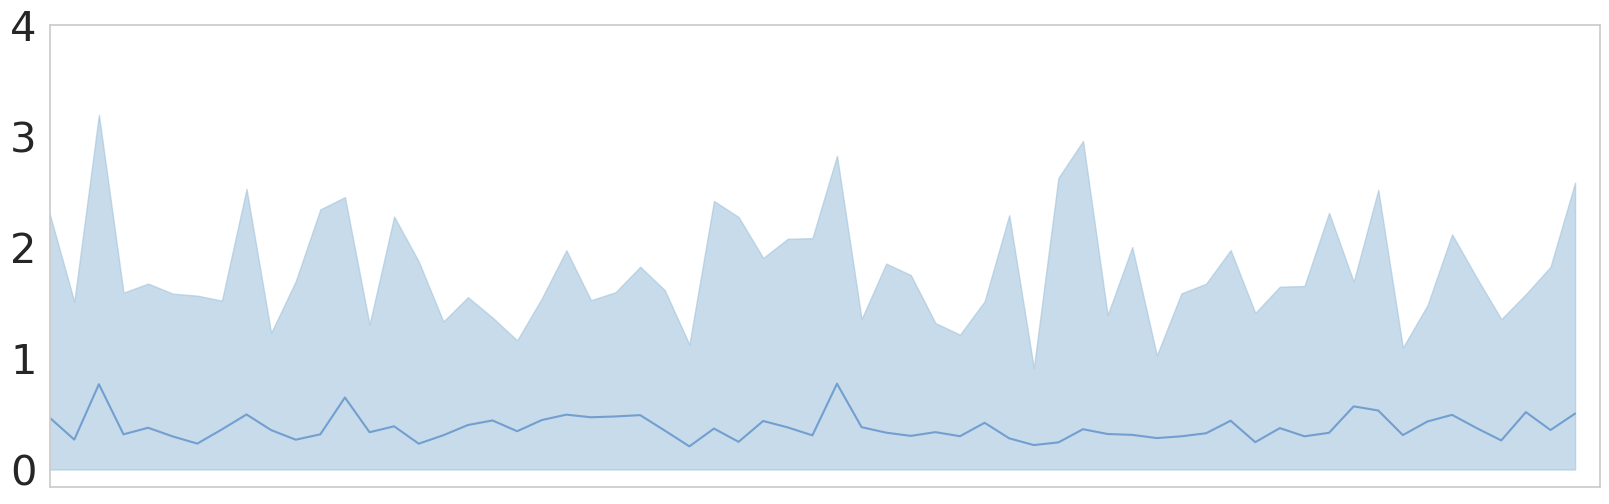

In [23]:
# 8. Activation visualization in shifed domain

act = model.act[0]  
act_np = act.cpu().detach().numpy()  
print("skewness:", skew(act_np.reshape(-1)))

activation_means = np.mean(act_np, axis=0)  
activation_max = np.max(act_np, axis=0)
activation_min = np.min(act_np, axis=0)

x = np.arange(len(activation_means)) 

sns.set(style="whitegrid")

plt.figure(figsize=(20, 6))
plt.grid(False)
sns.lineplot(x=x, y=activation_means, color="#729FCF", linewidth=1.5)  

plt.fill_between(x, activation_min, activation_max, color="#A3C4DC", alpha=0.6, label="Min-Max Region")  
plt.xticks([], fontsize=12)  
plt.xlim(1,64)
plt.yticks(ticks=np.arange(0, 5, 1), fontsize=30) 
plt.savefig("near_ood_act.png")

plt.show()


Test Dataset RMSE with rectification: 0.5594
Bias with rectification: -0.0071
Variance with rectification: 0.3956


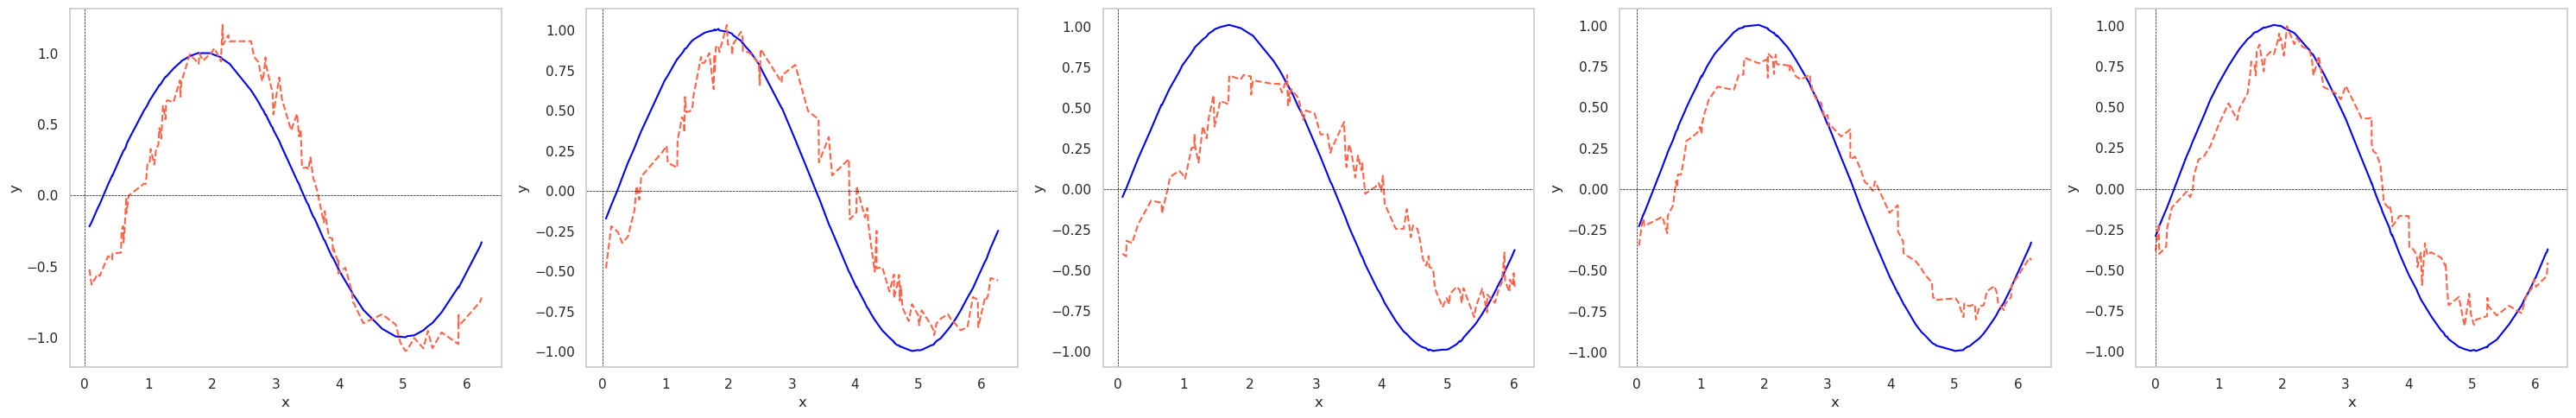

In [25]:
# 8. Evaluation on Domain Shift (Interpolation) with rectification

model.rectification = True
model.change_threshold(1)

with torch.no_grad():
    predictions = model(x_tensor).squeeze()  # 예측 값

rmse = torch.sqrt(torch.mean((predictions - ground_truth) ** 2)).item()
print(f"Test Dataset RMSE with rectification: {rmse:.4f}")

bias = torch.mean(predictions - ground_truth).item()
print(f"Bias with rectification: {bias:.4f}")

variance = torch.mean((predictions - torch.mean(predictions)) ** 2).item()
print(f"Variance with rectification: {variance:.4f}")

plt.figure(figsize=(30, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.plot(x_all[index], y_all[index], label='True', color='blue')
    plt.plot(x_all[index], predictions[index].numpy().flatten(), label='Rectified Prediction', linestyle='--', color='tomato')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

plt.savefig("nead_ood_react_sin.png")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


x_tensor shape: torch.Size([100, 100, 1])
y_tensor shape: torch.Size([100, 100, 1])
y_tensor_true shape: torch.Size([100, 100, 1])


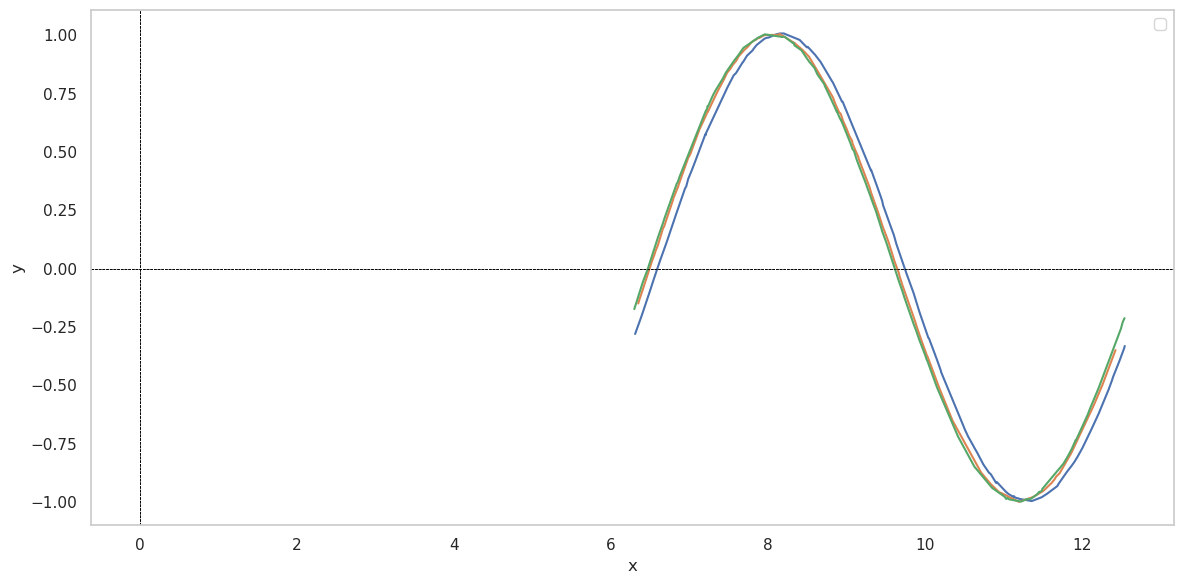

In [10]:
# 7. Create Domain Shift Data (Interpolation) Far Out-of-Distribution
num_test = 100
num_samples = 100
x_all = []
y_all = []
y_all_true = []

for _ in range(num_train):
    x = np.random.uniform(2*np.pi, 4*np.pi, num_samples)
    sort_indices = np.argsort(x)
    x = x[sort_indices]
    shift = np.random.uniform(0, 0.1*np.pi) 
    y = 1*np.sin(x - shift) + np.random.uniform(0,0.01,num_samples)  
    y_true = 1*np.sin(x-shift)
    x_all.append(x)
    y_all.append(y)
    y_all_true.append(y_true)



x_all = np.array(x_all)
y_all = np.array(y_all)
y_all_true = np.array(y_all_true)

x_tensor = torch.FloatTensor(x_all)  
y_tensor = torch.FloatTensor(y_all)  
y_tensor_true = torch.FloatTensor(y_all_true) 

x_tensor = x_tensor.view(num_test, num_samples, 1) 
y_tensor = y_tensor.view(num_test, num_samples, 1)  
y_tensor_true = y_tensor_true.view(num_test, num_samples, 1) 

print("x_tensor shape:", x_tensor.shape) 
print("y_tensor shape:", y_tensor.shape)  
print("y_tensor_true shape:", y_tensor_true.shape)  

plt.figure(figsize=(12, 6))
for i in range(3):  
    plt.plot(x_all[i], y_all[i])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

Test Dataset RMSE: 6.7771
Bias: -0.1839
Variance: 46.8062


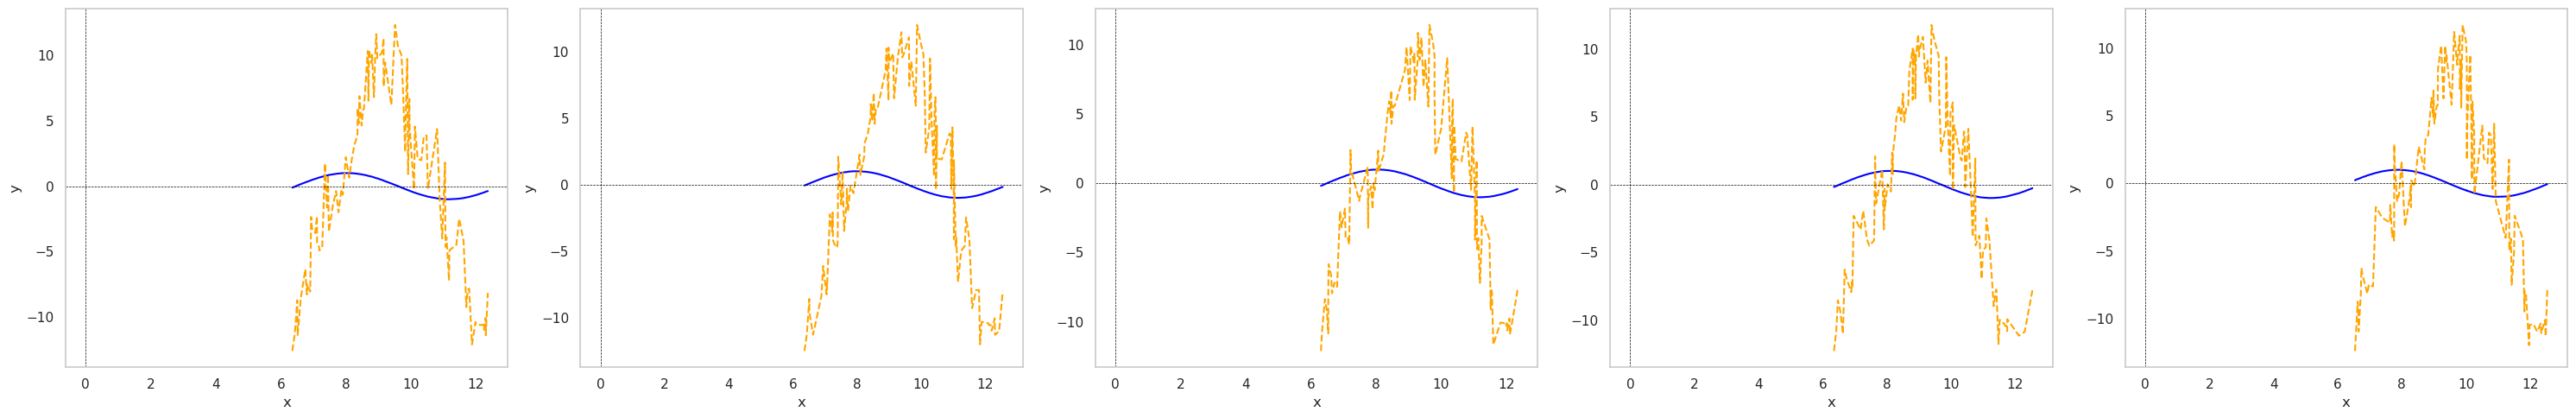

In [11]:
# 8. Evaluation on Far Out-of-Distribution without rectification

model.eval()  
model.rectification = False
model.istest = True
model.clear_activations()

with torch.no_grad():
    predictions = model(x_tensor).squeeze()  
    ground_truth = y_tensor_true.squeeze()  

rmse = torch.sqrt(torch.mean((predictions - ground_truth) ** 2)).item()
print(f"Test Dataset RMSE: {rmse:.4f}")

bias = torch.mean(predictions - ground_truth).item()
print(f"Bias: {bias:.4f}")

variance = torch.mean((predictions - torch.mean(predictions)) ** 2).item()
print(f"Variance: {variance:.4f}")

num_samples_to_visualize = 5
indices = np.random.choice(len(x_tensor), num_samples_to_visualize, replace=False)

plt.figure(figsize=(30, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.plot(x_all[index], y_all[index], label='True', color='blue')
    plt.plot(x_all[index], predictions[index].numpy().flatten(), label='Prediction', linestyle='--', color='orange')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

plt.savefig("far_ood_no_react_sin.png")
plt.tight_layout()
plt.show()

skewness: 2.474622116270443


/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jiwoo/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


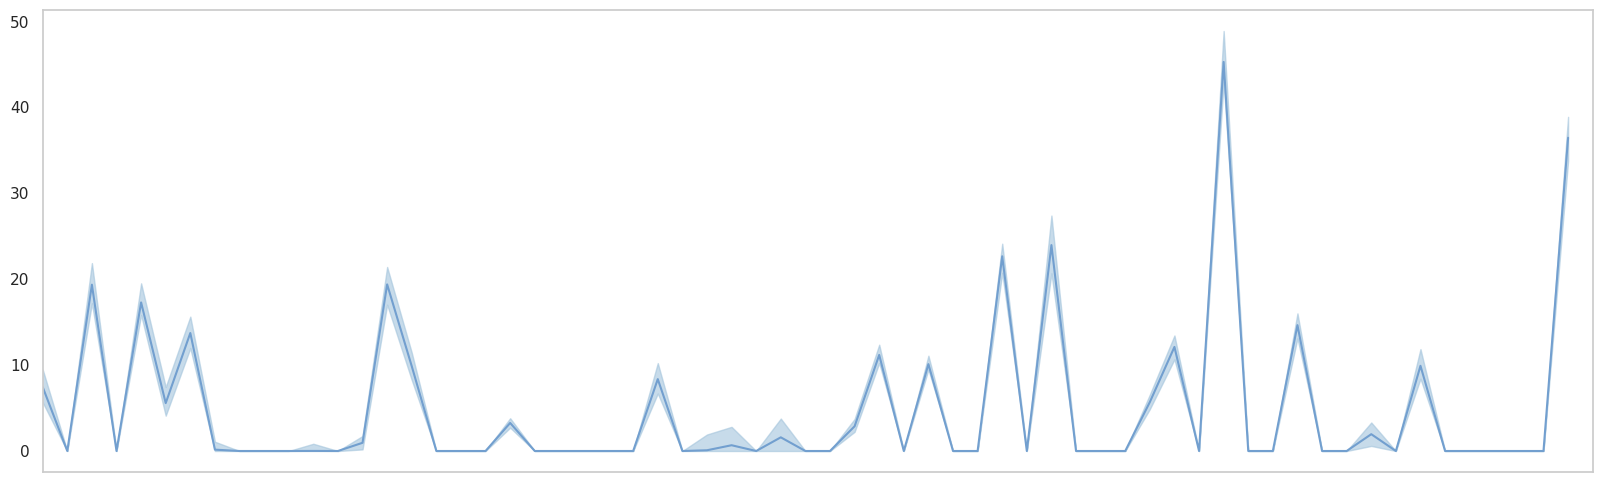

In [12]:
# 9. Activation visualization in Far Out-of-Distribution

act = model.act[0]  
act_np = act.cpu().detach().numpy()  
print("skewness:", skew(act_np.reshape(-1)))

activation_means = np.mean(act_np, axis=0)  
activation_max = np.max(act_np, axis=0)
activation_min = np.min(act_np, axis=0)

x = np.arange(len(activation_means)) 

sns.set(style="whitegrid")

plt.figure(figsize=(20, 6))
plt.grid(False)
sns.lineplot(x=x, y=activation_means, color="#729FCF", linewidth=1.5)  

plt.fill_between(x, activation_min, activation_max, color="#A3C4DC", alpha=0.6, label="Min-Max Region")  
plt.xticks([], fontsize=12)  
plt.xlim(1,64)
plt.savefig("far_ood_act.png")

plt.show()


Test Dataset RMSE with rectification: 1.0213
Bias with rectification: -0.0014
Variance with rectification: 1.4564


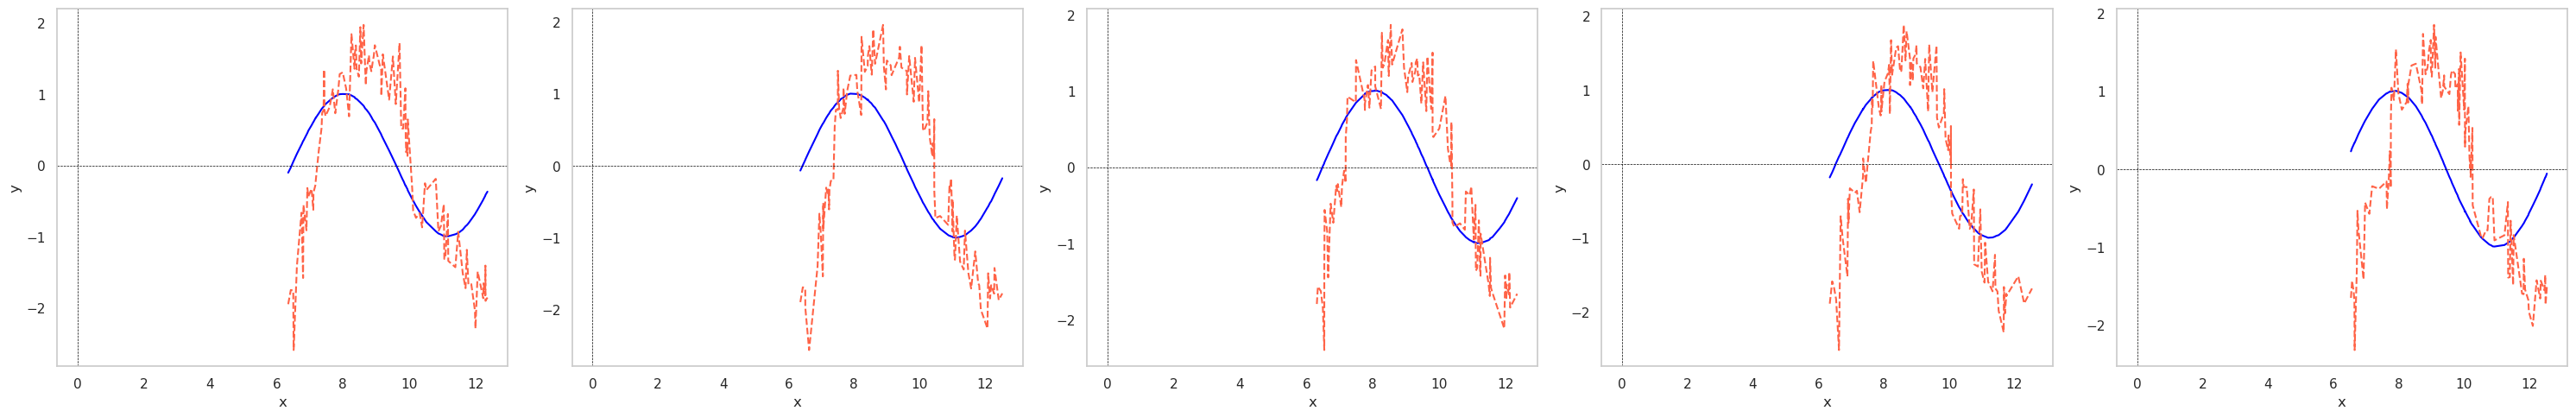

In [15]:
# 10. Evaluation on Far Out-of-Distribution with rectification

model.rectification = True
model.change_threshold(3)

with torch.no_grad():
    predictions = model(x_tensor).squeeze() 

rmse = torch.sqrt(torch.mean((predictions - ground_truth) ** 2)).item()
print(f"Test Dataset RMSE with rectification: {rmse:.4f}")

bias = torch.mean(predictions - ground_truth).item()
print(f"Bias with rectification: {bias:.4f}")

variance = torch.mean((predictions - torch.mean(predictions)) ** 2).item()
print(f"Variance with rectification: {variance:.4f}")

plt.figure(figsize=(30, 5))
for i, index in enumerate(indices):
    plt.subplot(1, num_samples_to_visualize, i + 1)
    plt.plot(x_all[index], y_all[index], label='True', color='blue')
    plt.plot(x_all[index], predictions[index].numpy().flatten(), label='Rectified Prediction', linestyle='--', color='tomato')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()

plt.savefig("far_ood_react_sin.png")
plt.tight_layout()
plt.show()